# Introducing the Keras Functional API on Vertex AI Platform

**Learning Objectives**
  1. Understand embeddings and how to create them with the feature column API
  1. Understand Deep and Wide models and when to use them
  1. Learn how to deploy the Model to Vertex AI and make predictions with the Keras model
  1. Understand the Keras functional API and how to build a deep and wide model with it

## Introduction

In the last notebook, we learned about the Keras Sequential API. The [Keras Functional API](https://www.tensorflow.org/guide/keras#functional_api) provides an alternate way of building models which is more flexible. With the Functional API, we can build models with more complex topologies, multiple input or output layers, shared layers or non-sequential data flows (e.g. residual layers).

In this notebook we'll use what we learned about feature columns to build a Wide & Deep model. Recall, that the idea behind Wide & Deep models is to join the two methods of learning through memorization and generalization by making a wide linear model and a deep learning model to accommodate both. You can have a look at the original research paper here: [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

<img src='assets/wide_deep.png' width='80%'>
<sup>(image: https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)</sup>

The Wide part of the model is associated with the memory element. In this case, we train a linear model with a wide set of crossed features and learn the correlation of this related data with the assigned label. The Deep part of the model is associated with the generalization element where we use embedding vectors for features. The best embeddings are then learned through the training process. While both of these methods can work well alone, Wide & Deep models excel by combining these techniques together.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/labs/4_keras_functional_api.ipynb) -- try to complete that notebook first before reviewing this solution notebook.


In [22]:
# Use the chown command to change the ownership of the repository.
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [23]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.3.0 || pip install tensorflow==2.3.0

tensorflow==2.3.0


Kindly ignore the deprecation warnings and incompatibility errors.

In [24]:
# Install the required numpy version.
!pip install numpy==1.21.0

Kindly ignore the deprecation warnings and incompatibility errors.

Start by importing the necessary libraries for this lab.

ORIGIANL
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow import feature_column as fc

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, DenseFeatures, concatenate)
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

In [25]:
# Importing necessary modules/libraries such as numpy, pandas and datetime.


import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2.3.0


In [26]:
# It sets the backend of matplotlib to the 'inline' backend. The output of plotting commands is displayed inline within frontends, directly
# below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
%matplotlib inline

## Load raw data 

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [27]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Feb 27 06:24 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Feb 27 06:24 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Feb 27 06:24 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](2_dataset_api.ipynb). For this lab we will also include some additional engineered features in our model. In particular, we will compute the difference in latitude and longitude, as well as the Euclidean distance between the pick-up and drop-off locations. We can accomplish this by adding these new features to the features dictionary with the function `add_engineered_features` below. 

Note that we include a call to this function when collecting our features dict and labels in the `features_and_labels` function below as well. 

In [28]:
# Selecting specific CSV_COLUMNS, LABEL_COLUMN, DEFAULTS, UNWANTED_COLS.
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


# Create an input function reading a file using the Dataset API
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
        
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


# Reading CSV files into a dataset.
def create_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)
    
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Feature columns for Wide and Deep model

For the Wide columns, we will create feature columns of crossed features. To do this, we'll create a collection of Tensorflow feature columns to pass to the `tf.feature_column.crossed_column` constructor. The Deep columns will consist of numeric columns and the embedding columns we want to create. 

In [29]:
# TODO 1

# 1. Bucketize latitudes and longitudes
NBUCKETS = 16
latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

fc_bucketized_plat = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_longitude"), boundaries=lonbuckets)
fc_bucketized_plon = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_latitude"), boundaries=latbuckets)
fc_bucketized_dlat = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_longitude"), boundaries=lonbuckets)
fc_bucketized_dlon = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_latitude"), boundaries=latbuckets)

# 2. Cross features for locations
fc_crossed_dloc = fc.crossed_column(
    [fc_bucketized_dlat, fc_bucketized_dlon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_ploc = fc.crossed_column(
    [fc_bucketized_plat, fc_bucketized_plon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_pd_pair = fc.crossed_column(
    [fc_crossed_dloc, fc_crossed_ploc],
    hash_bucket_size=NBUCKETS**4)

# 3. Create embedding columns for the crossed columns
fc_pd_pair = fc.embedding_column(categorical_column=fc_crossed_pd_pair, dimension=3)
fc_dloc = fc.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)
fc_ploc = fc.embedding_column(categorical_column=fc_crossed_ploc, dimension=3)

### Gather list of feature columns

Next we gather the list of wide and deep feature columns we'll pass to our Wide & Deep model in Tensorflow. Recall, wide columns are sparse, have linear relationship with the output while continuous columns are deep, have a complex relationship with the output. We will use our previously bucketized columns to collect crossed feature columns and sparse feature columns for our wide columns, and embedding feature columns and numeric features columns for the deep columns.

In [30]:
# TODO 2
wide_columns = [
    # One-hot encoded feature crosses
    fc.indicator_column(fc_crossed_dloc),
    fc.indicator_column(fc_crossed_ploc),
    fc.indicator_column(fc_crossed_pd_pair)
]

deep_columns = [
    # Embedding_column to "group" together ...
    fc.embedding_column(fc_crossed_pd_pair, dimension=10),

    # Numeric columns
    fc.numeric_column("pickup_latitude"),
    fc.numeric_column("pickup_longitude"),
    fc.numeric_column("dropoff_longitude"),
    fc.numeric_column("dropoff_latitude")
]

## Build a Wide and Deep model in Keras

To build a wide-and-deep network, we connect the sparse (i.e. wide) features directly to the output node, but pass the dense (i.e. deep) features through a set of fully connected layers. Here’s that model architecture looks using the Functional API.

First, we'll create our input columns using [tf.keras.layers.Input](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Input).

In [31]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS
}

Then, we'll define our custom RMSE evaluation metric and build our wide and deep model.

In [32]:
# Here, tf.reduce_mean computes the mean of elements across dimensions of a tensor.
# tf.sqrt Computes element-wise square root of the input tensor.
# tf.square computes square of x element-wise.
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# TODO 3
def build_model(dnn_hidden_units):
    # Create the deep part of model
    deep = DenseFeatures(deep_columns, name='deep_inputs')(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation='relu')(deep) 

    # Create the wide part of model
    wide = DenseFeatures(wide_columns, name='wide_inputs')(inputs)

    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide], name='combined')

    # Map the combined outputs into a single prediction value
    output = Dense(units=1, activation=None, name='prediction')(combined)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers, each with 10 neurons, for the deep part of our model. We can also use `plot_model` to see a diagram of the model we've created.

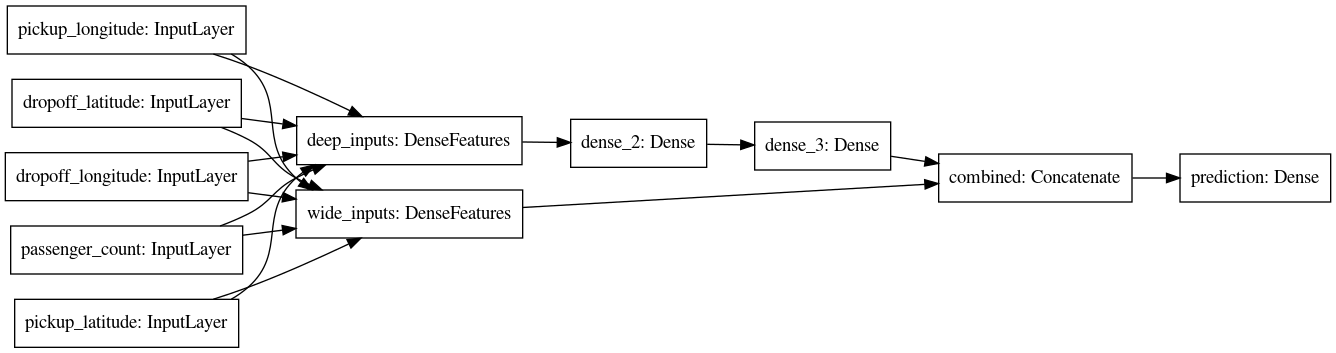

In [33]:
HIDDEN_UNITS = [10,10]

# Calling the build model
model = build_model(dnn_hidden_units=HIDDEN_UNITS)

# Converts a Keras plot_model to see a diagram of the model that we have created.
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

Next, we'll set up our training variables, create our datasets for training and validation, and train our model.

(We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.)

In [34]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='../data/taxi-train*',
    batch_size=BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    pattern='../data/taxi-valid*',
    batch_size=BATCH_SIZE,
    mode='eval').take(NUM_EVAL_EXAMPLES//1000)

In [35]:
%%time
# Here, %%time prints the wall time for the entire cell
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "./taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True) # start fresh each time

history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(OUTDIR)])

2022-02-27 23:47:19.625693: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/50


2022-02-27 23:47:30.918890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 600 of 1000
2022-02-27 23:47:37.437488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:221] Shuffle buffer filled.


1/1 [==============================] - 3s 3s/step - loss: 247.6673 - rmse: 15.7374 - mse: 247.6673 - val_loss: 247.0494 - val_rmse: 15.7107 - val_mse: 247.0494
Epoch 2/50


2022-02-27 23:47:40.674405: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


1/1 [==============================] - ETA: 0s - loss: 233.2153 - rmse: 15.2714 - mse: 233.2153

2022-02-27 23:47:41.121947: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./taxi_trained/train/plugins/profile/2022_02_27_23_47_41
2022-02-27 23:47:41.135235: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./taxi_trained/train/plugins/profile/2022_02_27_23_47_41/tensorflow-2-6-20220226-215208.trace.json.gz
2022-02-27 23:47:41.143828: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./taxi_trained/train/plugins/profile/2022_02_27_23_47_41
2022-02-27 23:47:41.143944: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./taxi_trained/train/plugins/profile/2022_02_27_23_47_41/tensorflow-2-6-20220226-215208.memory_profile.json.gz
2022-02-27 23:47:41.144365: I tensorflow/python/profiler/internal/profiler_wrapper.cc:111] Creating directory: ./taxi_trained/train/plugins/profile/2022_02_27_23_47_41Dumped tool data 

1/1 [==============================] - 2s 2s/step - loss: 233.2153 - rmse: 15.2714 - mse: 233.2153 - val_loss: 246.4097 - val_rmse: 15.6840 - val_mse: 246.4097
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 219.3283 - rmse: 14.8097 - mse: 219.3283 - val_loss: 241.9832 - val_rmse: 15.5471 - val_mse: 241.9832
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 230.7043 - rmse: 15.1890 - mse: 230.7043 - val_loss: 244.9543 - val_rmse: 15.6376 - val_mse: 244.9543
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 201.3523 - rmse: 14.1899 - mse: 201.3523 - val_loss: 243.3998 - val_rmse: 15.5836 - val_mse: 243.3998
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 246.8419 - rmse: 15.7112 - mse: 246.8419 - val_loss: 245.0233 - val_rmse: 15.6400 - val_mse: 245.0233
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 191.3155 - rmse: 13.8317 - mse: 191.3155 - val_loss: 239.7175 - val_rmse: 15.4676 - val

Just as before, we can examine the history to see how the RMSE changes through training on the train set and validation set. 

<AxesSubplot:>

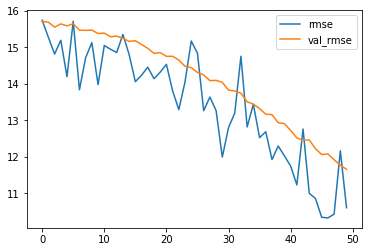

In [36]:
RMSE_COLS = ['rmse', 'val_rmse']

# Pandas DataFrame is two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns).
pd.DataFrame(history.history)[RMSE_COLS].plot()

In [37]:
model.predict(
    x={
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

array([[6.609981]], dtype=float32)

In [38]:
#Export and Deploy YOur Model

In [39]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

INFO:tensorflow:Assets written to: ./export/savedmodel/20220227234953/assets
INFO:tensorflow:Assets written to: ./export/savedmodel/20220227234953/assets


In [40]:
#Deploy Model to Vertex AI

In [41]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare_keras_functional-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: taxifare_keras_functional-20220227234953


In [42]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.


In [43]:
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

Copying file://./export/savedmodel/20220227234953/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220227234953/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220227234953/variables/variables.index [Content-Type=application/octet-stream]...
/ [3 files][ 10.4 MiB/ 10.4 MiB]                                                
Operation completed over 3 objects/10.4 MiB.                                     


In [44]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/333736501253/locations/us-central1/models/5715881565737713664/operations/4273393297315069952
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/333736501253/locations/us-central1/models/5715881565737713664
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/333736501253/locations/us-central1/models/5715881565737713664')


In [45]:
MACHINE_TYPE = "n1-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/333736501253/locations/us-central1/endpoints/2019063988410646528/operations/999276368216719360
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/333736501253/locations/us-central1/endpoints/2019063988410646528
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/333736501253/locations/us-central1/endpoints/2019063988410646528')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/333736501253/locations/us-central1/endpoints/2019063988410646528
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/333736501253/locations/us-central1/endpoints/2019063988410646528/operations/7202984854919577600
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/333736501253

<img src='assets/taxi_fare_keras_func_model.png' width='80%'>
<sup>(image:Your model in Vertex AI)</sup>

In [46]:
instance = {
    "pickup_longitude": -73.982683,
    "pickup_latitude": 40.742104,
    "dropoff_longitude": -73.983766,
    "dropoff_latitude": 40.755174,
    "passenger_count": 3.0,
}

In [47]:
endpoint.predict([instance])

Prediction(predictions=[[6.60998106]], deployed_model_id='2284336561774395392', explanations=None)

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License